# Zero-Shot Anomaly Localization using CLIP and Faster R-CNN

Load all necessary libraries and set up the computation device (CPU or GPU).

In [1]:
import os

# Set the desired GPU (e.g., GPU 0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Import other libraries after setting the environment variable
import torch

# Check the available device
print(f"Using GPU: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Using GPU: 0 - NVIDIA RTX 6000 Ada Generation


#### Now install OpenAI's CLIP library directly from its source repository.

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

#### Import necessary libraries

In [41]:
import os
import json
import random
from io import BytesIO
import requests
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.image_list import ImageList 


from dotenv import load_dotenv
from roboflow import Roboflow
import clip
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2

#### Load the pre-trained Faster R-CNN model for object/region proposal and the pre-trained CLIP model for image-text feature extraction. Both models are set to evaluation mode.

In [16]:
# Load Faster R-CNN Model (using ResNet50 FPN V2 weights)
frcnn_weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
faster_rcnn_model = fasterrcnn_resnet50_fpn_v2(weights=frcnn_weights)
faster_rcnn_model = faster_rcnn_model.to(DEVICE)
faster_rcnn_model.eval() # Set model to evaluation mode

# Get the image transformations expected by this Faster R-CNN model
faster_rcnn_preprocess = frcnn_weights.transforms()

# Load CLIP Model and its corresponding preprocessor
# Available models: clip.available_models() => e.g., 'ViT-B/32', 'RN50x16' etc.
clip_model_name = 'ViT-B/32' #ViT-B/16
clip_model, clip_preprocess = clip.load(clip_model_name, device=DEVICE)
clip_model.eval() # Set model to evaluation mode

print(f"Loaded Faster R-CNN with weights: {frcnn_weights}")
print(f"Loaded CLIP model: {clip_model_name}")
print(f"CLIP expected image size: {clip_model.visual.input_resolution}")

Loaded Faster R-CNN with weights: FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
Loaded CLIP model: ViT-B/32
CLIP expected image size: 224


#### Download Datasets from Links or of your own

In [24]:
rf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))
project = rf.workspace("objdet-odjxg").project("screw-7iwvy")
version = project.version(1)
dataset = version.download("coco")
print("Dataset downloaded")
IMAGE_PATH = os.path.join(dataset.location, 'test')
ANNOTATIONS_PATH = os.path.join(TEST_IMAGE_DIR, '_annotations.coco.json')

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded


# Object Detection Helper Functions

This code defines several helper functions for an object detection task, likely using PyTorch and COCO-formatted data.

1.  **`Workspace_image(file_path)`**:
    * Loads an image from the specified `file_path` using the PIL library.
    * Ensures the image is in RGB format.

2.  **`preprocess_image(image)`**:
    * Takes a PIL `image` as input.
    * Applies a basic transformation using `torchvision.transforms` to convert the image into a PyTorch Tensor, suitable for model input.

3.  **`load_coco_annotations(annotations_path)`**:
    * Opens and reads a JSON file specified by `annotations_path`, assuming it follows the COCO annotation format.
    * Returns two lists: one containing image metadata and one containing object annotations.

4.  **`plot_comparison(image, ground_truth_boxes, predicted_boxes, labels=None)`**:
    * Uses `matplotlib` to display the results.
    * Creates a figure with two subplots:
        * Left subplot: Shows the original `image` with ground truth bounding boxes drawn in red.
        * Right subplot: Shows the original `image` with predicted ("candidate") bounding boxes drawn in green. Optionally displays `labels` near the predicted boxes.
    * Assumes bounding boxes are in `[x_min, y_min, x_max, y_max]` format for both ground truth and predictions. *(Note: The ground truth plot code assumes this format, but COCO may provide `[x_min, y_min, width, height]`. Ensure consistency when calling this function).*

In [43]:
def fetch_image(file_path: str) -> Image.Image:
    return Image.open(file_path).convert("RGB")

def preprocess_image(image):
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image)

def load_coco_annotations(annotations_path):
    with open(annotations_path, "r") as f:
        data = json.load(f)
    return data["images"], data["annotations"]

def plot_comparison(image, ground_truth_boxes, predicted_boxes, labels=None, scores=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot Ground Truth
    axes[0].imshow(image)
    axes[0].set_title("Ground Truth", fontsize=14, fontweight="bold")
    for box in ground_truth_boxes:
        x_min, y_min, x_max, y_max = box
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="red", facecolor="none")
        axes[0].add_patch(rect)

    # Plot Predictions
    axes[1].imshow(image)
    axes[1].set_title("Predictions", fontsize=14, fontweight="bold")
    for i, box in enumerate(predicted_boxes):
        x_min, y_min, x_max, y_max = box
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="green", facecolor="none")
        axes[1].add_patch(rect)

        # Add label and score if available
        if labels and scores and i < len(labels) and i < len(scores):
            axes[1].text(
                x_min,
                y_min - 10,
                f"{labels[i]} ({scores[i]:.2f})",
                fontsize=10,
                color="white",
                bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
            )
        elif labels and i < len(labels):
            axes[1].text(
                x_min,
                y_min - 10,
                labels[i],
                fontsize=10,
                color="white",
                bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
            )

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Image Object Detection and Comparison

This script performs object detection on a sample image from a dataset and visualizes the results alongside the ground truth.

**Workflow:**

1.  **`detect_and_compare(images, annotations, model)` Function:**
    * Takes image metadata, annotations (COCO format), and a pre-loaded detection model (`model`, e.g., Faster R-CNN).
    * For each image derived from the annotations:
        * Loads the image file.
        * Preprocesses the image for the model.
        * Extracts ground truth bounding boxes from annotations.
        * Runs the `model` in inference mode (`torch.no_grad()`) to get **predicted bounding boxes** (referred to as "candidate boxes").
        * Calls `plot_comparison` to display the image with ground truth boxes (red) and predicted boxes (green) side-by-side.

2.  **Main Execution Logic:**
    * Loads all image metadata and annotations from the specified `ANNOTATIONS_PATH`.
    * Filters the list of images to ensure the corresponding files exist locally.
    * Selects **one random image** (`images[:1]`) from the available images. (can be modified for n images)
    * Filters the annotations to keep only those belonging to the selected image.
    * Calls `detect_and_compare` to process this single image, generate the candidate boxes using the model, and display the comparison plot.

**Outcome:** The script processes one random image and displays a plot showing the original image twice: once with the actual object locations (ground truth) and once with the locations predicted by the model (candidate boxes).

Processing images...


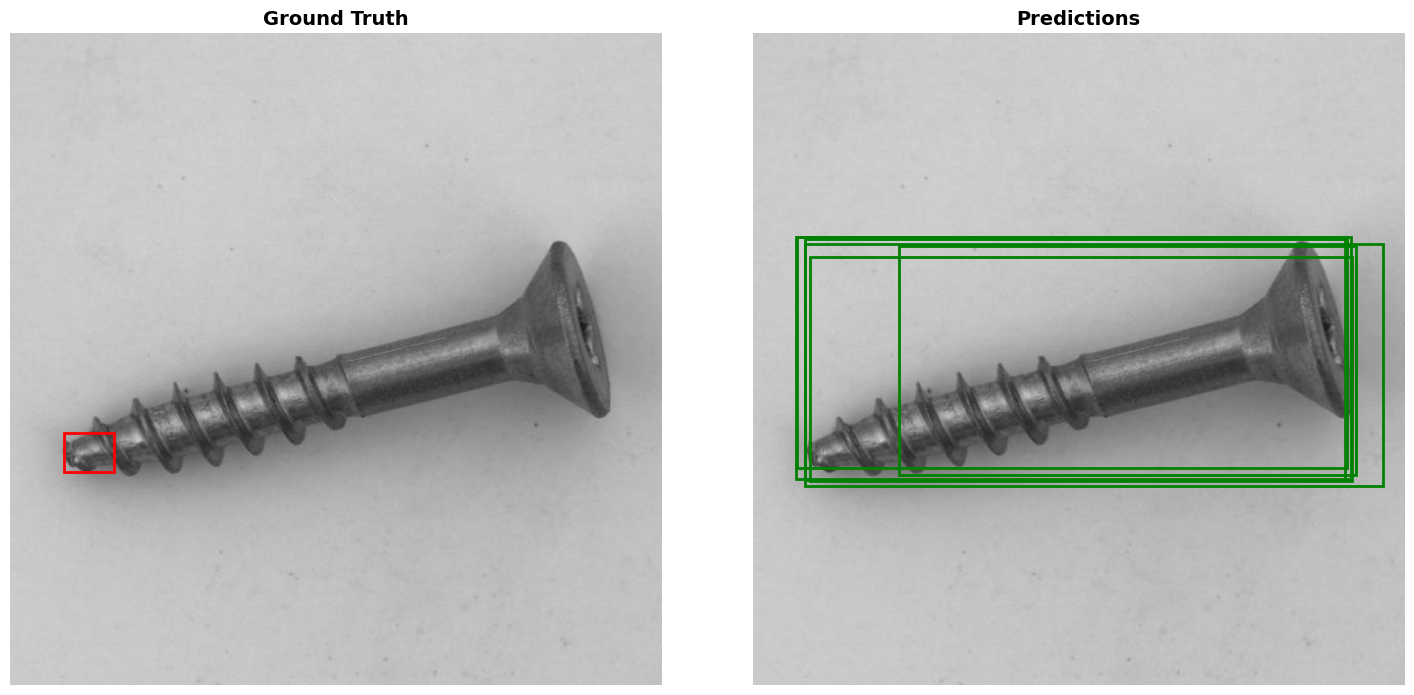

Processing complete.


In [44]:
def detect_and_compare(images, annotations, model):
    # Map image IDs to file names
    image_id_to_file = {img["id"]: img["file_name"] for img in images}

    for annotation in annotations:
        # Get associated image
        image_id = annotation["image_id"]
        if image_id not in image_id_to_file:
            print(f"Warning: Image ID {image_id} not found in dataset.")
            continue

        image_path = os.path.join(IMAGE_PATH, image_id_to_file[image_id])
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            continue

        image = fetch_image(image_path)
        image_pt = preprocess_image(image).to(DEVICE)

        # Ground truth boxes
        ground_truth_boxes = [
            [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            for bbox in [obj["bbox"] for obj in annotations if obj["image_id"] == image_id]
        ]

        # Model predictions
        with torch.no_grad():
            frcnn_result = model([image_pt])[0]
        predicted_boxes = frcnn_result["boxes"].detach().cpu().numpy()
        plot_comparison(image, ground_truth_boxes, predicted_boxes)


images, annotations = load_coco_annotations(ANNOTATIONS_PATH)
images = [img for img in images if os.path.exists(os.path.join(IMAGE_PATH, img["file_name"]))]

random.shuffle(images)
selected_images = images[:1]

selected_image_ids = {img["id"] for img in selected_images}
selected_annotations = [ann for ann in annotations if ann["image_id"] in selected_image_ids]

# Run detection and comparison
print("Processing images...")
detect_and_compare(selected_images, selected_annotations, faster_rcnn)
print("Processing complete.")

# RPN Proposal Visualization Functions

* **`compute_rpn_proposals(image)`**: Executes the Faster R-CNN transform, backbone, and RPN stages on an input image to extract raw region proposal bounding boxes. Returns proposals as a CPU tensor.
* **`plot_proposals(image, proposals)`**: Displays the input `image` overlaid with up to 1000 of the RPN `proposals` (blue boxes). Prints the number of boxes plotted.

In [36]:
def compute_rpn_proposals(image: Image.Image) -> torch.Tensor:
    image_pt = preprocess_image(image).to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        transformed_images, _ = faster_rcnn.transform(image_pt)
        features = faster_rcnn.backbone(transformed_images.tensors)
        rpn_output, _ = faster_rcnn.rpn(transformed_images, features)
        all_region_proposals = rpn_output[0]
    return all_region_proposals.detach().cpu()

def plot_proposals(image, proposals):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(image)
    ax.set_title("Region Proposals (RPN Output)", fontsize=14, fontweight="bold")
    num_to_plot = min(1000, proposals.shape[0])
    print(f"Plotting {num_to_plot} proposals...")
    for box in proposals[:num_to_plot]:
        x_min, y_min, x_max, y_max = box
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=1, edgecolor="blue", facecolor="none", alpha=0.7)
        ax.add_patch(rect)

    ax.axis("off")
    plt.tight_layout()
    plt.show()


# RPN Visualization Execution (Single Random Image)

* Loads COCO image metadata (annotations ignored).
* Selects **one random image** metadata entry.
* For the selected image:
    * Constructs path and loads the image (`Workspace_image`).
    * Computes RPN proposals (`compute_rpn_proposals`).
    * Prints the total number of proposals generated.
    * Displays the image with (up to 1000) proposals plotted (`plot_proposals`).

Selected 1 images for processing.

Extracting and plotting region proposals...

Processing image: 012_png.rf.66869af4d22714552b00bbf2dd0dbd61.jpg
Total number of region proposal boxes generated by RPN: 986
Plotting 986 proposals...


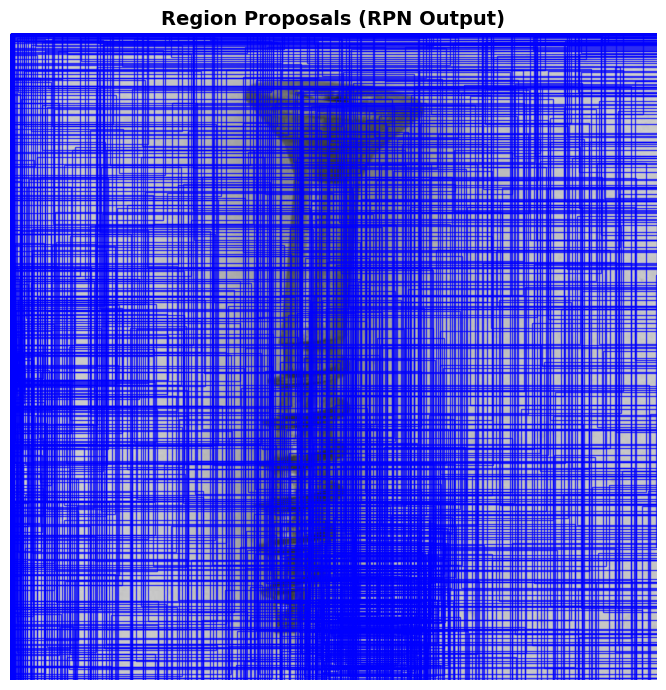


Processing complete.


In [37]:
images_metadata, _ = load_coco_annotations(ANNOTATIONS_PATH) # Ignore annotations_data
random.shuffle(images_metadata)
selected_images_metadata = images_metadata[:1]
print(f"Selected {len(selected_images_metadata)} images for processing.")

# Process multiple images
print("\nExtracting and plotting region proposals...")
for img_meta in selected_images_metadata:
    image_path = os.path.join(IMAGE_PATH, img_meta["file_name"])
    print(f"\nProcessing image: {img_meta['file_name']}")
    image = fetch_image(image_path)
    region_proposals = compute_rpn_proposals(image)
    print(f"Total number of region proposal boxes generated by RPN: {region_proposals.shape[0]}")
    plot_proposals(image, region_proposals)

print("\nProcessing complete.")

####  CLIP Defect Detection functions

* **`load_coco_annotations(annotations_path)`**: Loads image metadata and annotations from a COCO JSON file.
* **`detect_defective_areas(...)`**: Uses a CLIP model (`model`, `processor`) to find the *single best* bounding box (`boxes`) within an image (`image_pt`) that matches the given text `prompts` based on cosine similarity. Returns the top-scoring box and its similarity score.

In [ ]:
def load_coco_annotations(annotations_path):
    with open(annotations_path, "r") as f:
        data = json.load(f)
    return data["images"], data["annotations"]

# CLIP-based defect detection within screws
def detect_defective_areas(model, processor, prompts, image_pt, boxes, device=DEVICE):
    """Detect specific defective areas within screws using CLIP similarity scores."""
    height, width = image_pt.shape[-2:]

    model.eval()
    tokenized_query = clip.tokenize(prompts).to(device)
    text_features = model.encode_text(tokenized_query)
    norm_text_features = F.normalize(text_features, p=2, dim=-1).mean(dim=0, keepdim=True)

    best_box = None
    best_score = -np.inf
    all_scores = []

    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        x_max, y_max = min(width, x_max), min(height, y_max)

        if x_min > x_max or x_min > width or y_min > y_max or y_min > height:
            continue

        cropped_image = image_pt[:, y_min:y_max+1, x_min:x_max+1]
        if not torch.prod(torch.tensor(cropped_image.shape)):
            continue

        cropped_image = processor(transforms.functional.to_pil_image(cropped_image)).unsqueeze(0).to(device)
        image_features = model.encode_image(cropped_image)
        norm_image_features = F.normalize(image_features, p=2, dim=-1)

        similarity = torch.dot(norm_image_features.view(-1), norm_text_features.view(-1))
        all_scores.append((box, similarity.item()))

        if similarity > best_score:
            best_score = similarity
            best_box = box

    all_scores = sorted(all_scores, key=lambda x: x[1], reverse=True)  # Sort by similarity score
    top_boxes = [x[0] for x in all_scores[:1]]  # Top 1 defect areas
    top_scores = [x[1] for x in all_scores[:1]]

    return top_boxes, top_scores

### RPN Proposal + Top CLIP Defect Visualization

* Loads COCO data, selects 16 random images/annotations.
* Defines text prompts for screw thread defects or fracture.
* **For each image:**
    * Generates candidate boxes using Faster R-CNN's RPN.
    * Uses `detect_defective_areas` (CLIP-based) to find the **single highest-scoring** candidate box matching the defect prompts.
    * Visualizes ground truth boxes alongside this single best CLIP-detected box using `plot_comparison`.

Detecting screw_thread_defect areas...


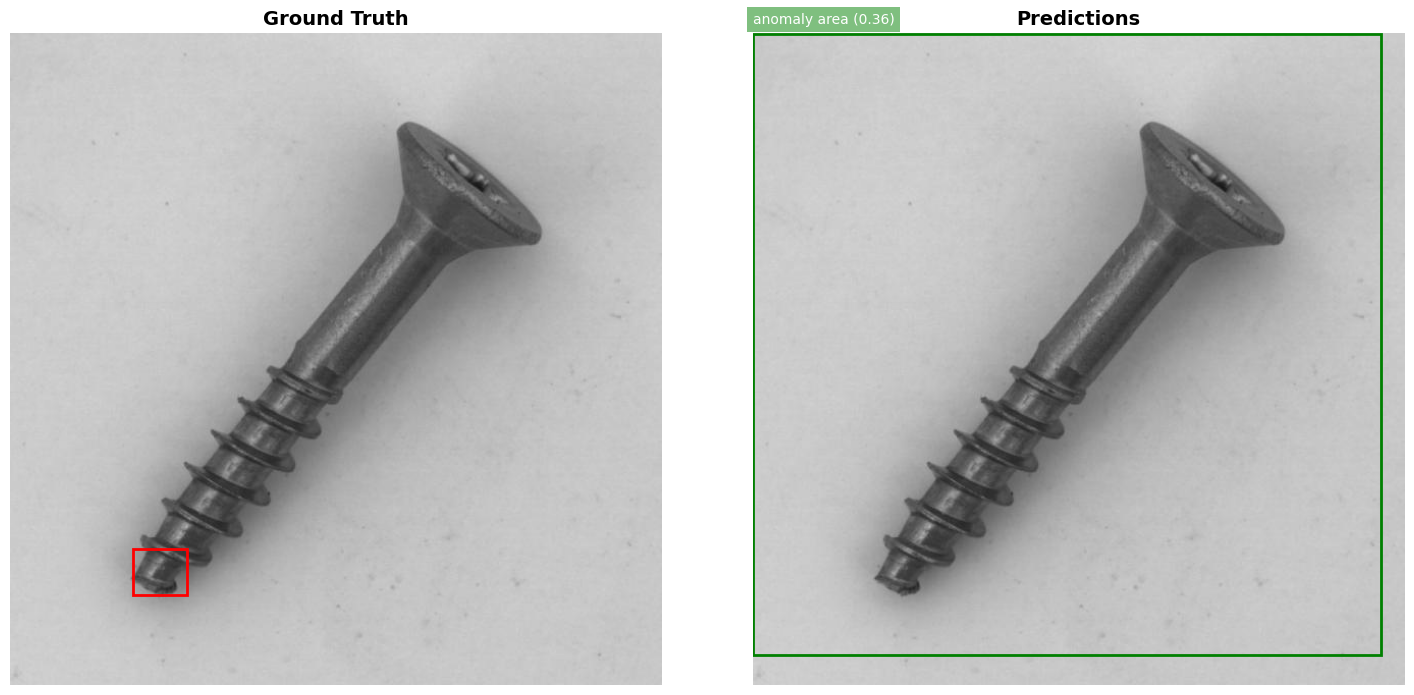

Detecting screw_thread_defect areas...


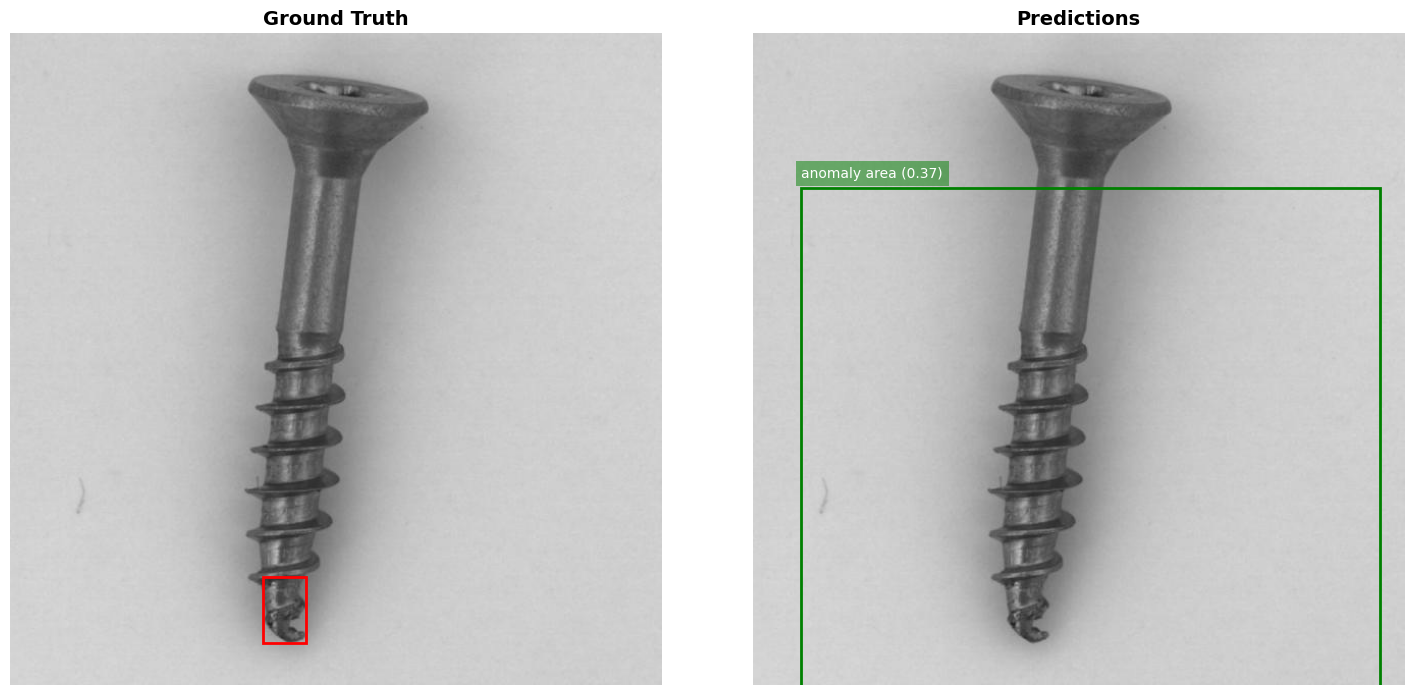

Detecting screw_thread_defect areas...


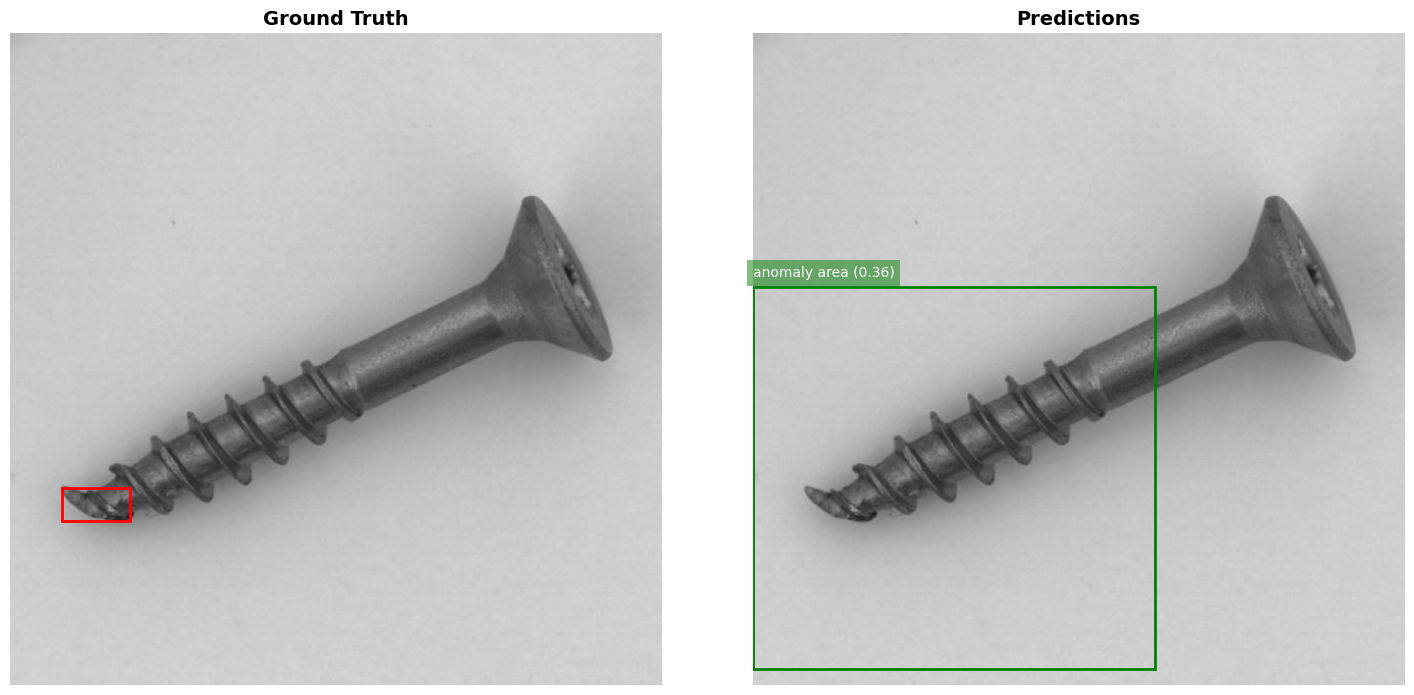

Detecting screw_thread_defect areas...


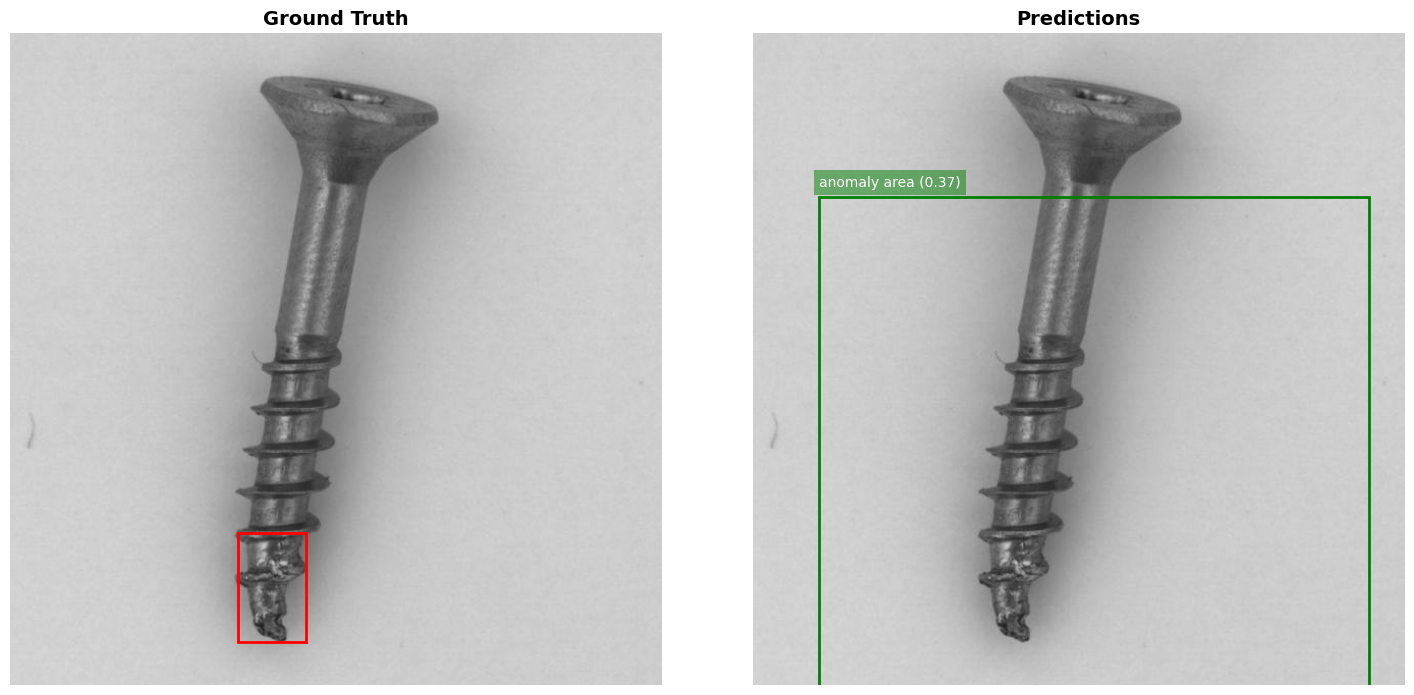

Detecting screw_thread_defect areas...


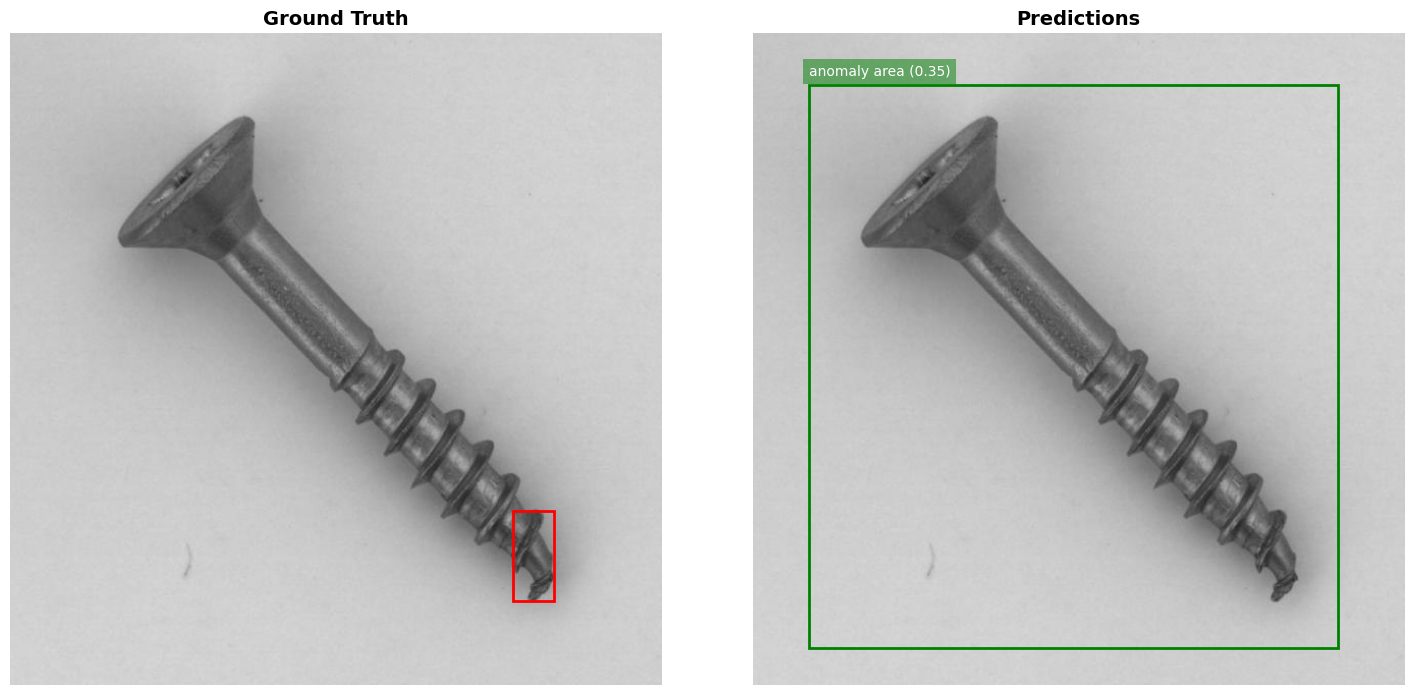

Detecting screw_thread_defect areas...


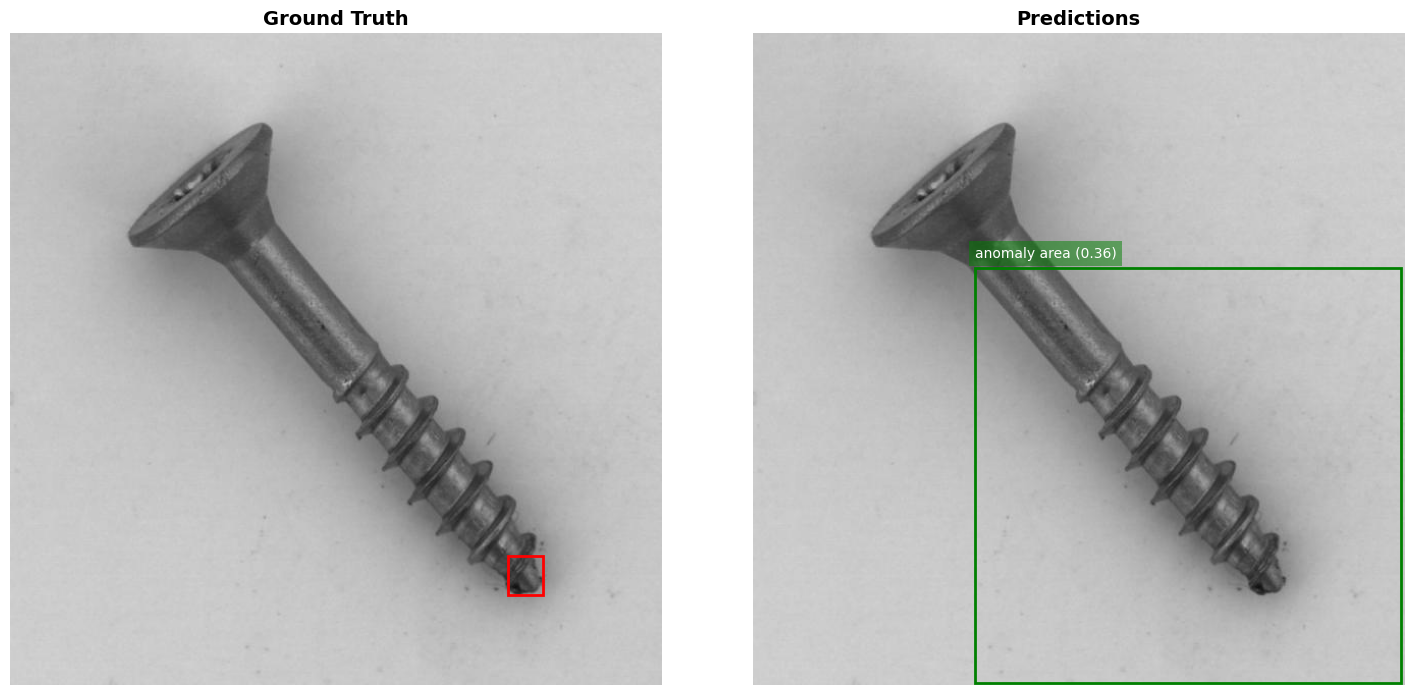

Detecting screw_thread_defect areas...


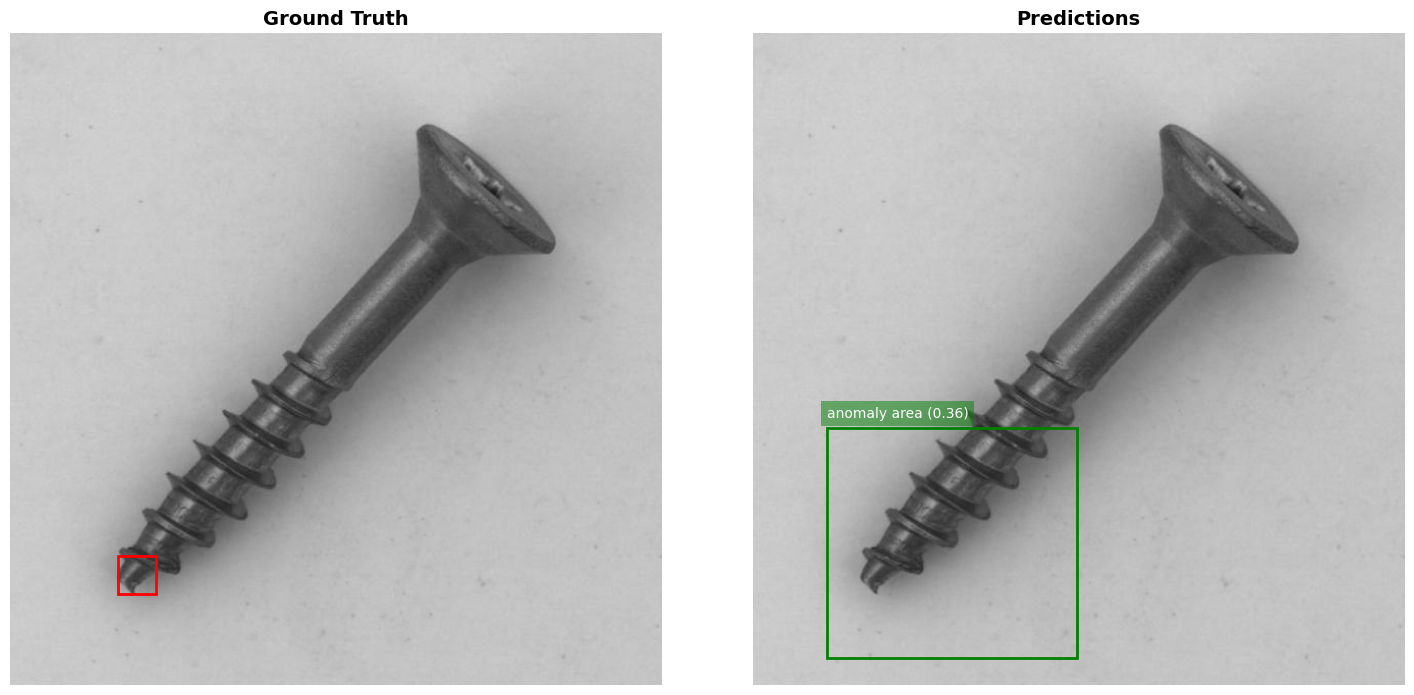

Detecting screw_thread_defect areas...


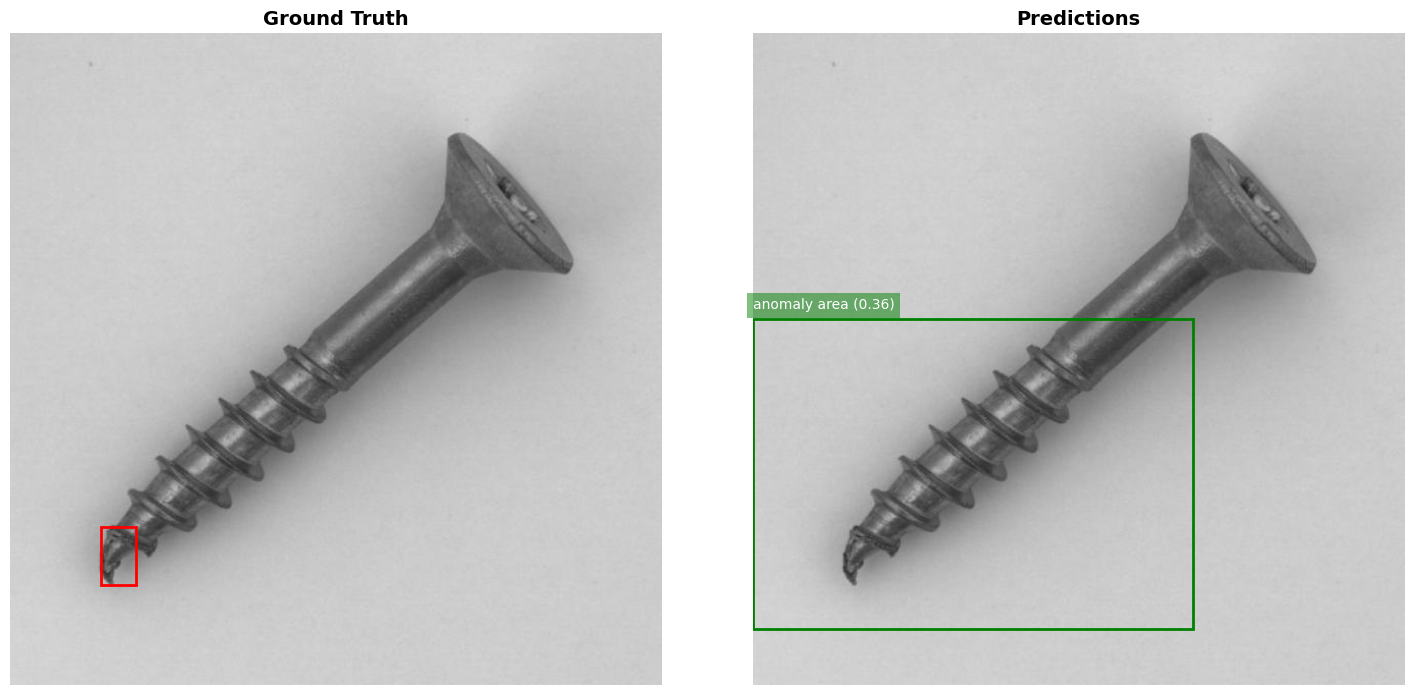

Detecting screw_thread_defect areas...


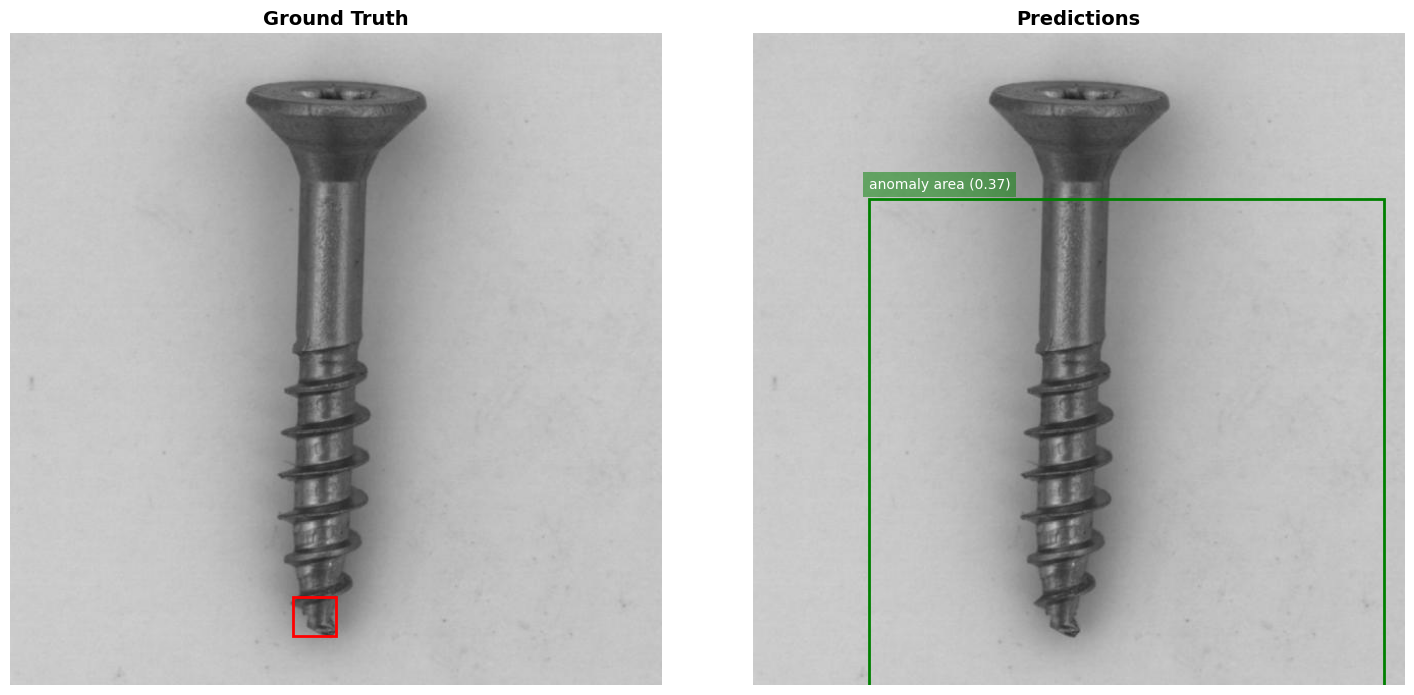

Detecting screw_thread_defect areas...


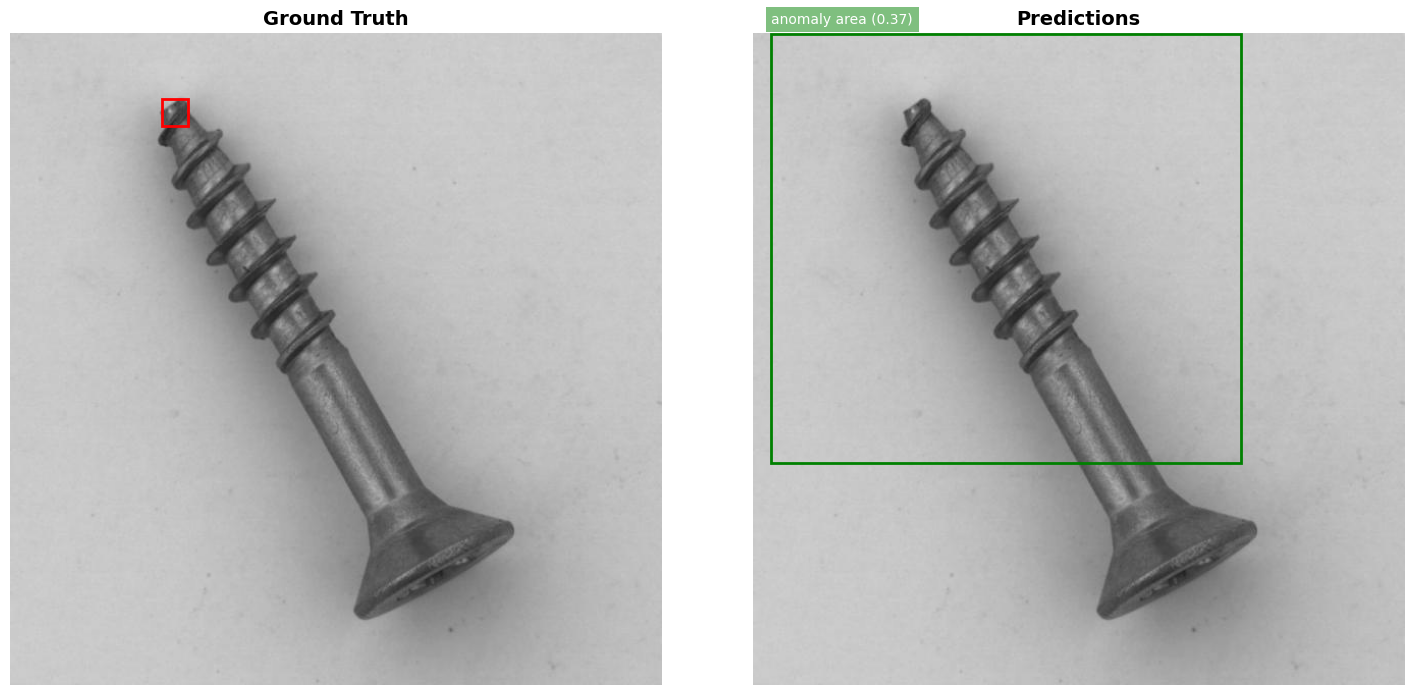

Detecting screw_thread_defect areas...


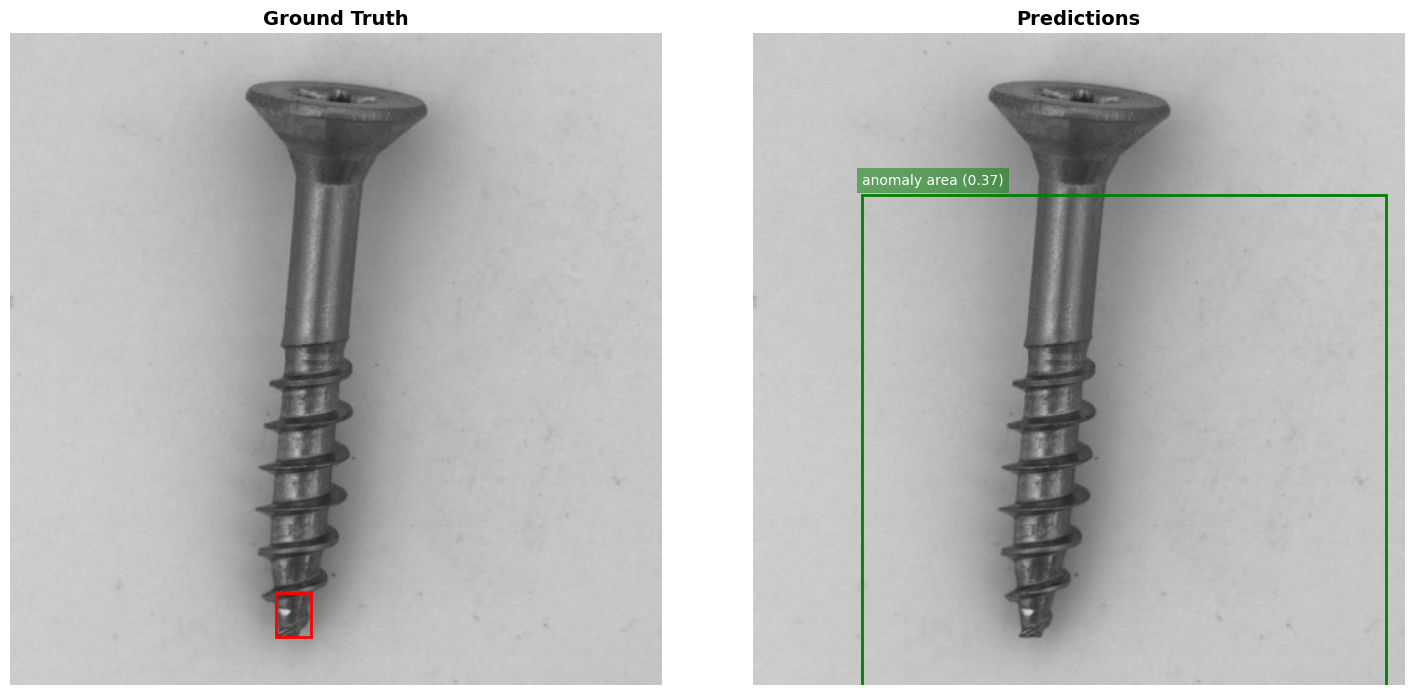

Detecting screw_thread_defect areas...


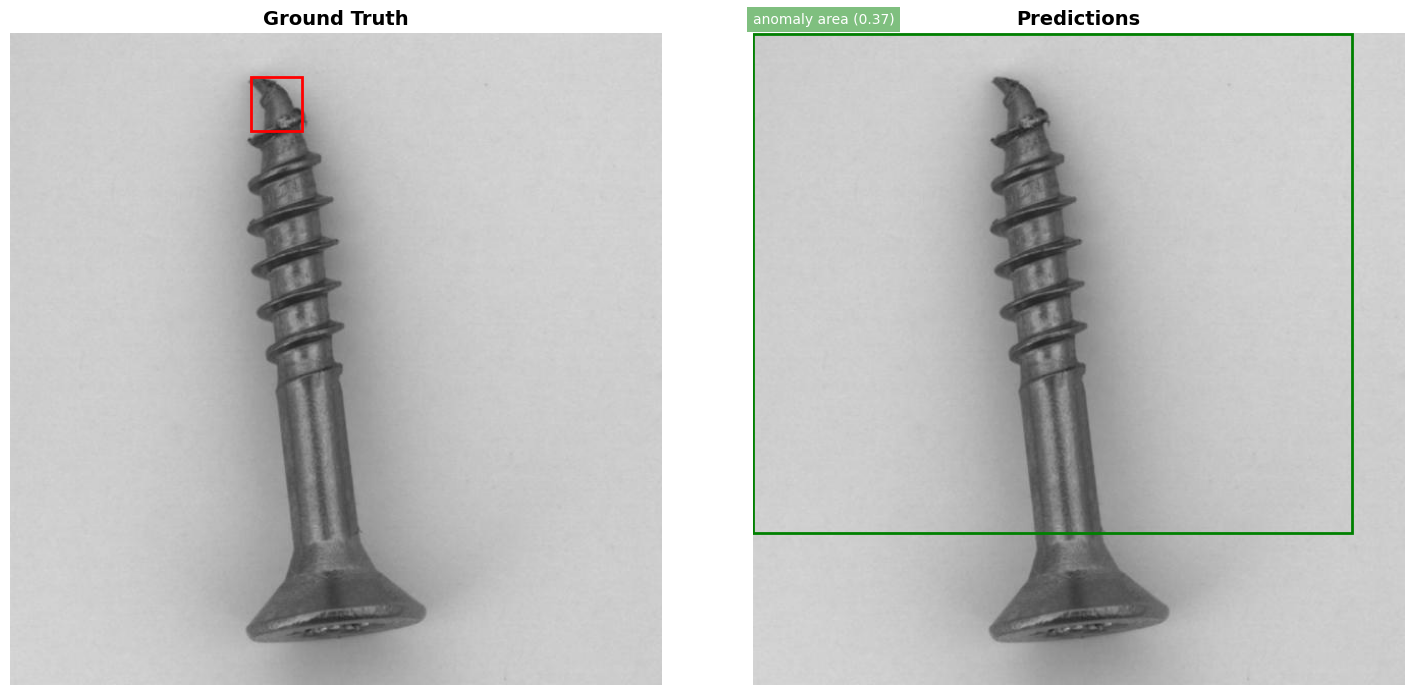

Detecting screw_thread_defect areas...


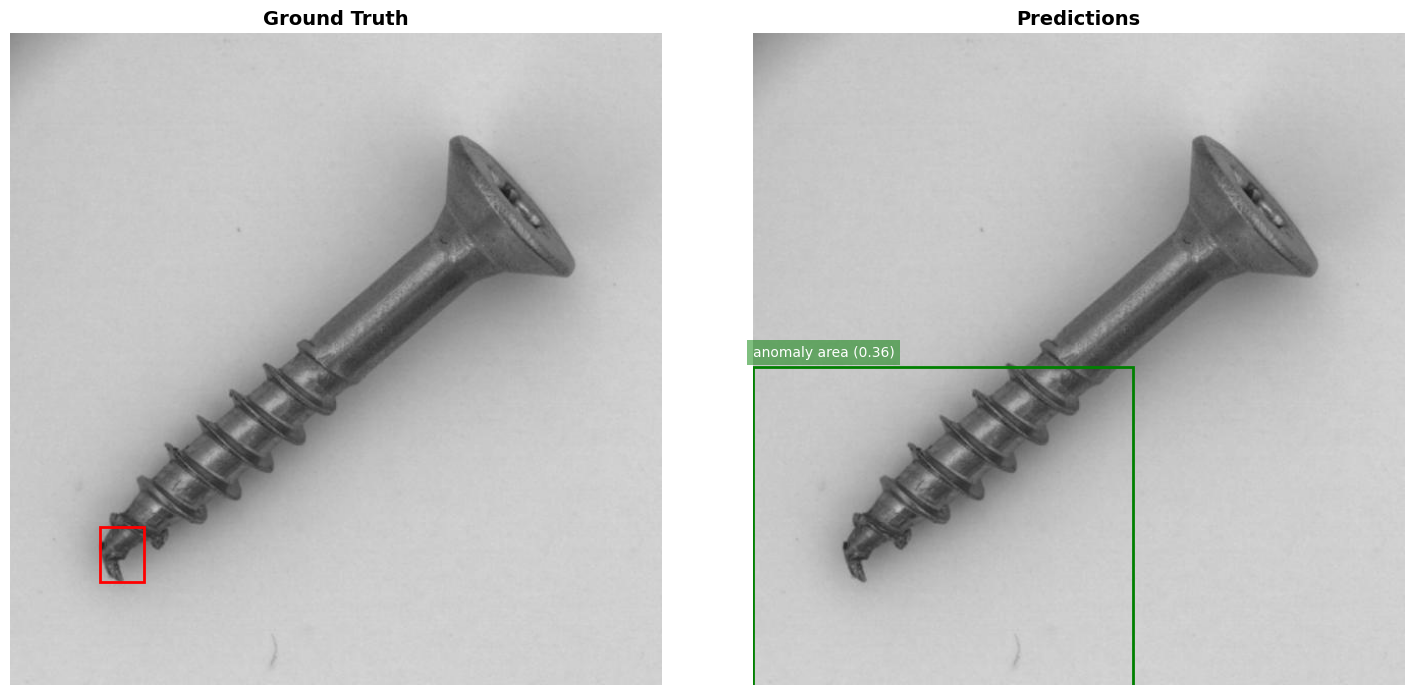

Detecting screw_thread_defect areas...


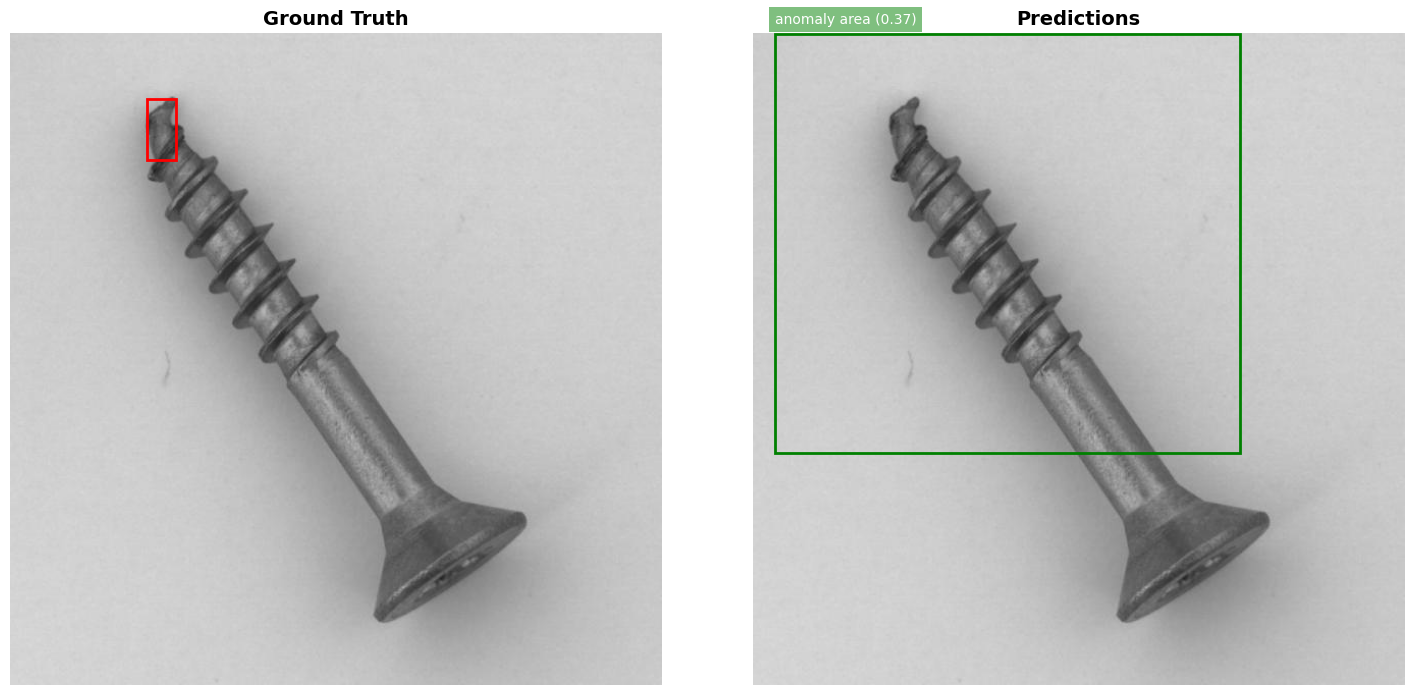

Detecting screw_thread_defect areas...


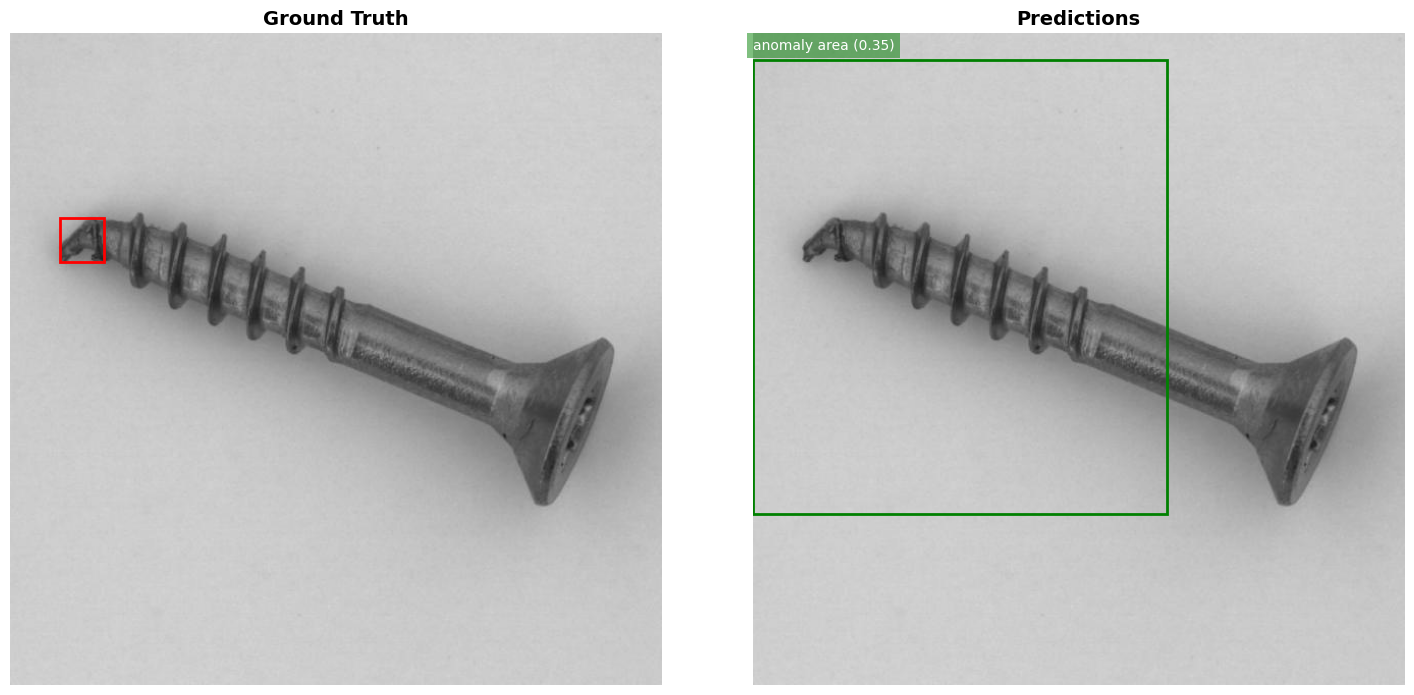

Detecting screw_thread_defect areas...


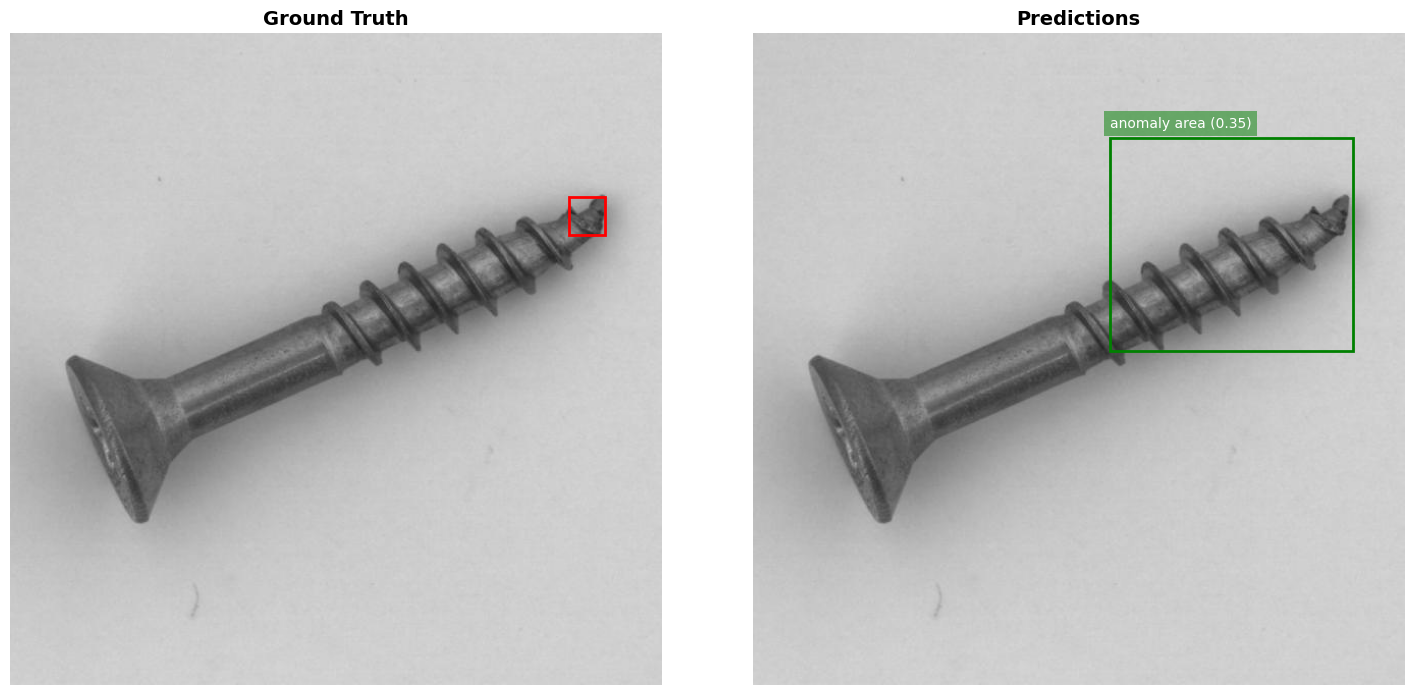

In [51]:
images, annotations = load_coco_annotations(ANNOTATIONS_PATH)

# Map image IDs to file names
image_id_to_file = {img["id"]: img["file_name"] for img in images}
tensor_transform = transforms.ToTensor()
random.shuffle(images)
selected_images = images[:16]
selected_image_ids = {img["id"] for img in selected_images}
selected_annotations = [ann for ann in annotations if ann["image_id"] in selected_image_ids]

label_prompts = {
    "screw_thread_defect": [
        "a close-up of a damaged screw with deformed threads",
        "a metal screw with bent and uneven threading",
        "a self-tapping screw with broken and worn-out threads",
        "a defective screw with an irregular thread pattern",
        "a damaged screw with a chipped and twisted tip",
        "a partially deformed screw with thread defects",
        "a misaligned and worn-out screw thread close-up",
        "a bent screw with an unevenly cut thread surface",
        "a weathered screw with damaged and incomplete threading",
        "a close-up of a metal screw with a distorted thread profile"
    ]
}
#label_prompts = {
#     "fracture_xray": [
#         "an X-ray image showing a bone fracture",
#         "a close-up X-ray of a broken bone",
#         "a hairline fracture in a human bone X-ray",
#         "an X-ray scan displaying a displaced bone fracture",
#         "a fractured tibia seen in an X-ray",
#         "a spiral fracture visible in an X-ray image",
#         "an X-ray image of a femur with a complete break",
#         "a comminuted fracture in an X-ray scan",
#         "an X-ray showing a fractured wrist bone",
#         "a stress fracture in a foot X-ray",
#         "a medical X-ray highlighting a broken rib",
#         "a cracked bone visible in an X-ray report",
#         "an X-ray image of a fractured arm bone",
#         "an X-ray showing a fracture with metal plates",
#         "a compound fracture evident in a radiograph",
#         "an X-ray of a fractured clavicle",
#         "an ankle X-ray displaying a visible crack",
#         "an X-ray scan of a fractured humerus",
#         "a skull X-ray with a visible hairline fracture",
#         "an orthopedic X-ray showing a broken joint"
#     ]
# }


for img_data in selected_images:
    image_path = os.path.join(IMAGE_PATH, img_data["file_name"])
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        continue

    image = fetch_image(image_path)
    image_pt = tensor_transform(image).to(DEVICE)

    with torch.no_grad():
        input_tensor = image_pt.unsqueeze(0)
        features = faster_rcnn.backbone(input_tensor)
        image_sizes = [(image_pt.shape[1], image_pt.shape[2])]
        image_list = ImageList(input_tensor, image_sizes)
        proposals, _ = faster_rcnn.rpn(image_list, features)
        candidate_boxes = proposals[0].detach().cpu().numpy()

    matched_boxes = []
    matched_scores = []
    for label, prompts in label_prompts.items():
        print(f"Detecting {label} areas...")
        pred_boxes, pred_scores = detect_defective_areas(clip_model, clip_preprocess, prompts, image_pt, candidate_boxes)
        matched_boxes.extend(pred_boxes)
        matched_scores.extend(pred_scores)

    # Ground truth boxes
    ground_truth_boxes = [
        [ann["bbox"][0], ann["bbox"][1], ann["bbox"][0] + ann["bbox"][2], ann["bbox"][1] + ann["bbox"][3]]
        for ann in selected_annotations if ann["image_id"] == img_data["id"]
    ]

    # Visualization
    plot_comparison(image, ground_truth_boxes, matched_boxes, labels=["anomaly area"] * len(matched_boxes), scores=matched_scores)


#### Average IoU & CLIP Score Calculation

* Defines `calculate_iou` function for bounding box Intersection over Union.
* Initializes total IoU, total CLIP score, and total box count accumulators.
* **Iterates through images (intended to be part of a larger loop):**
    * Retrieves ground truth boxes (`gt_boxes`).
    * For each predicted box (`pred_box` in `matched_boxes` - *Note: Assumes `matched_boxes` holds predictions for the current image*):
        * Calculates the maximum IoU against all `gt_boxes`.
    * Adds the sum of these maximum IoUs to `total_iou`.
    * Adds the number of predicted boxes processed for IoU to `total_matched_boxes`.
    * Adds the sum of corresponding CLIP scores (`matched_scores` - *Note: Assumes `matched_scores` holds scores for the current image*) to `total_clip_score`.
* **After iterating through all images:**
    * Calculates the overall average IoU and average CLIP score.
    * Prints the final averages.

In [52]:
def calculate_iou(pred_box, gt_box):
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

total_iou = 0
total_clip_score = 0
total_matched_boxes = 0

for img_data in selected_images:
    image_id = img_data["id"]
    
    gt_boxes = [
        [ann["bbox"][0], ann["bbox"][1], ann["bbox"][0] + ann["bbox"][2], ann["bbox"][1] + ann["bbox"][3]]
        for ann in selected_annotations if ann["image_id"] == image_id
    ]
    
    if not gt_boxes:
        continue
    
    image_ious = []
    for pred_box in matched_boxes:
        box_ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
        if box_ious:
            image_ious.append(max(box_ious))  
    
    if image_ious:
        total_iou += sum(image_ious)
        total_matched_boxes += len(image_ious)
    
    total_clip_score += sum(matched_scores)

average_iou = total_iou / total_matched_boxes if total_matched_boxes > 0 else 0
average_clip_score = total_clip_score / total_matched_boxes if total_matched_boxes > 0 else 0

print(f"Average IoU across 16 images: {average_iou:.4f}")
print(f"Average CLIP score across 16 images: {average_clip_score:.4f}")

Average IoU across 16 images: 0.0017
Average CLIP score across 16 images: 0.3479
